This tutorial will demonstrate how you can train a PyTorch model to solve one classification problem and then use that model, with a few small changes, to solve a different classification problem. When we re-use a model in this way, it is called tranfer learning. 

The benefits: learning can be faster, more accurate, and does not require a large amount of training data and time spent on designing the solution to a problem is signifigantly less because you are reusing a model you have already trained.

In [1]:
#torch-specific imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

We'll also import some utilities to make it easier to work with our data. dataLoader allows us to import an entire folder of images and torchvision will allow us to visualize what we are doing with the data. (need to look up exactly what these do to make it read correctly)

In [2]:
#torchvision
import torchvision
from torchvision import datasets, models, transforms

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy

This is our scenario: we are working on labeling images with the types of furniture they feature. We have a small dataset and we've used it to train a model to recognize dressers. The model categorized an image as containing a dresser or not containing a dresser. Now we want to be able to reuse this model for a similar classification problem. We want our model to be able to recognize chairs as well as a more specific type of chair, a swivel chair. We only need a small statset to do this and we will only be trainig the last fully connected layer. Remember, using this approach will save us time and our classifcation will be more accurate even though we are using only a small set of images to train the new model. 

In [4]:
#might come back and make use of these if more clarity in process needed
#import torch.nn.functional as F
#from torch.utils.data import DataLoader
#from torchvision.utils import make_grid
#from torchvision import models, transforms, datasets

This next line of code tells pytorch where we are getting our computing power. In this case, we are using the local cpu, but alternatively, we could use cuda if we are working with a gpu (again clarify this)

In [5]:
device = torch.device('cpu')
#altered from the line with cuda
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

On to getting the data. In this case we already have a set of 16 images. Eight of these are dresser images and eight are not dressers. These are located in the project folder. We'll add those now. Note: this should point to a directory containing a train and test folder which each contain images for each class. Our two classes in this demonstration are chair and swivel chair

In [7]:
dir_data = './data/furniture_task'

In [11]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [12]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [14]:
image_datasets = {x: datasets.ImageFolder(os.path.join(dir_data, x), 
                                          data_transforms[x])
                for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=5,shuffle=True, num_workers=0)
                for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [19]:
print(class_names)

['chair', 'swivel_chair']


In [20]:
def imshow(inp, title):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

In [21]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

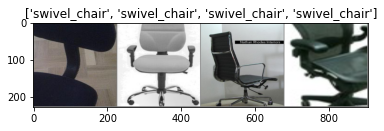

In [22]:
imshow(out, title=[class_names[x] for x in classes])

In [25]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [26]:
#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/audreymaldonado/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [27]:
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

In [28]:
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [29]:
# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()

In [30]:
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [31]:
model = train_model(model, criterion, optimizer,
                    step_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.7354 Acc: 0.5429
val Loss: 0.5686 Acc: 0.7667

Epoch 1/24
----------
train Loss: 0.6736 Acc: 0.5143
val Loss: 0.5268 Acc: 0.8000

Epoch 2/24
----------
train Loss: 0.6081 Acc: 0.6571
val Loss: 0.5048 Acc: 0.8000

Epoch 3/24
----------
train Loss: 0.5431 Acc: 0.8286
val Loss: 0.4334 Acc: 0.8667

Epoch 4/24
----------
train Loss: 0.4833 Acc: 0.8571
val Loss: 0.3908 Acc: 0.8667

Epoch 5/24
----------
train Loss: 0.5067 Acc: 0.7429
val Loss: 0.3727 Acc: 0.9000

Epoch 6/24
----------
train Loss: 0.5849 Acc: 0.6857
val Loss: 0.3507 Acc: 0.9000

Epoch 7/24
----------
train Loss: 0.4553 Acc: 0.8857
val Loss: 0.3599 Acc: 0.9000

Epoch 8/24
----------
train Loss: 0.4666 Acc: 0.8000
val Loss: 0.3601 Acc: 0.8667

Epoch 9/24
----------
train Loss: 0.4962 Acc: 0.8000
val Loss: 0.3569 Acc: 0.9000

Epoch 10/24
----------
train Loss: 0.4868 Acc: 0.8571
val Loss: 0.3605 Acc: 0.9000

Epoch 11/24
----------
train Loss: 0.5013 Acc: 0.8286
val Loss: 0.3626 Acc: 0.9000

Epoch 12/24
----------
t

In [32]:
# Freeze all but last fully connected layer
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

In [33]:
# Parameters of newly constructed modules have requires_grad=True by default

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

In [34]:
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

In [35]:
# Observe that only parameters of final layer are being optimized as
# opposed to before.

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

In [36]:
# Decay LR by a factor of 0.1 every 7 epochs

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8203 Acc: 0.3714
val Loss: 0.7238 Acc: 0.5000

Epoch 1/24
----------
train Loss: 0.6743 Acc: 0.6571
val Loss: 0.4424 Acc: 0.8000

Epoch 2/24
----------
train Loss: 0.4262 Acc: 0.8000
val Loss: 0.3916 Acc: 0.8333

Epoch 3/24
----------
train Loss: 0.4305 Acc: 0.8286
val Loss: 0.2669 Acc: 0.9333

Epoch 4/24
----------
train Loss: 0.5023 Acc: 0.7143
val Loss: 0.3479 Acc: 0.8333

Epoch 5/24
----------
train Loss: 0.4491 Acc: 0.8000
val Loss: 0.2646 Acc: 0.9667

Epoch 6/24
----------
train Loss: 0.5217 Acc: 0.6857
val Loss: 0.2651 Acc: 0.9333

Epoch 7/24
----------
train Loss: 0.2797 Acc: 0.8571
val Loss: 0.2472 Acc: 0.9333

Epoch 8/24
----------
train Loss: 0.3587 Acc: 0.8286
val Loss: 0.2343 Acc: 0.9667

Epoch 9/24
----------
train Loss: 0.3269 Acc: 0.8000
val Loss: 0.2541 Acc: 0.9333

Epoch 10/24
----------
train Loss: 0.4612 Acc: 0.7714
val Loss: 0.2357 Acc: 0.9333

Epoch 11/24
----------
train Loss: 0.3127 Acc: 0.9429
val Loss: 0.2269 Acc: 0.9333

Ep

In [37]:
# torch_model_archive
# upload this archive to boon.ai
# use this to identify dressers and nightstands

# save the model locally so you can upload it to boon.ai
torch.save(model, 'furniture_model.pth')

#model = torch.load('furniture_model.pth')

## more on resnet: 
https://pytorch.org/hub/pytorch_vision_resnet/

## source for furniture training images: 
https://www.kaggle.com/c/day-3-kaggle-competition/data
we'll set up our model to differentiate between chairs and swivel chairs using 20 training images for each and 15 validation images for each of our two classes.<br>
## pytorch's beginner tutorial:  
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html


This is where you start working with boonAi. We will upload a mixed batch of new pictures that are either chairs or swibvel chairs, upload our pickled model (now stored in the same folder we are working) and apply the model to the problem of classifying the unlabeled images.

In [3]:
#environment
import boonsdk
app = boonsdk.app_from_keyfile("../../../apikeys/apikey.json")
#unlabeled image file upload
#model upload

In [6]:
dataset = app.datasets.create_dataset(
    "furniture-dataset", 
    boonsdk.DatasetType.Classification
)
#

BoonSdkSecurityException: <BoonSdkRequestException msg=>

In [ ]:
# import app.assets.batch_upload_directory('./data/unlabeled_furniture')
#these assets should be part of the newly named dataset

In [ ]:
# model = upload_pretrained_model(furniture_model, './furnituremodel.pth')
# apply model to newly uploaded images?